In [1]:
import torch

from dataclasses import dataclass, field
from matplotlib import pyplot as plt
import numpy as np
import sys

sys.path.append("../..")

# FLOPs of the mLSTM cell

In [2]:
@dataclass
class mLSTMChunkwiseConfig:
    """The input shapes of the mLSTM kernel."""

    chunk_size: int = 64
    num_chunks: int = 1
    head_dimension: int = 128
    num_heads: int = 1


@dataclass
class FLOPCounterConfig:
    """FLOP factor configuration."""

    factor_exp: int = 1
    factor_max: int = 1
    factor_mask: int = 1


@dataclass
class mLSTMChunkwiseFLOPCountConfig:
    mlstm: mLSTMChunkwiseConfig = field(default_factory=mLSTMChunkwiseConfig)
    flop_counter: FLOPCounterConfig = field(default_factory=FLOPCounterConfig)

## FLOP counting chunkwise

In [3]:
%load_ext autoreload
%autoreload 2
from mlstm_kernels.flops_utils import (
    count_flops_mlstm_chunkwise_fw,
    count_flops_fw_H,
    count_flops_fw_C,
)

In [4]:
total_flops, fw_C_flops, fw_h_flops = count_flops_mlstm_chunkwise_fw(
    L=64, Nc=3, dqk=1024, dv=1024, Nh=1, factor_exp=1, factor_mask=1, factor_max=1
)

In [5]:
total_flops / 1e6, fw_C_flops / 1e6, fw_h_flops / 1e6

(662.112498, 611.651535, 50.460963)

## FLOPs vs Chunk Size

The maximum chunk size is between 700 and 800, then we would compute more flops than necessary. 

In [6]:
def make_chunkwise_flop_chunksize_sweep(
    seq_len, chunk_sizes: list[int], dqk, dv, Nh, factor_exp, factor_max, factor_mask
):
    num_chunks = [seq_len // chunk_size for chunk_size in chunk_sizes]

    num_chunks = np.array(num_chunks)
    chunk_sizes = np.array(chunk_sizes)

    flop_results = []
    for chunk_size, num_chunk in zip(chunk_sizes, num_chunks):
        total_flops, fw_C_flops, fw_h_flops = count_flops_mlstm_chunkwise_fw(
            L=chunk_size,
            Nc=num_chunk,
            dqk=dqk,
            dv=dv,
            Nh=Nh,
            factor_exp=factor_exp,
            factor_mask=factor_mask,
            factor_max=factor_max,
        )
        flop_results.append([total_flops, fw_C_flops, fw_h_flops])
        print(
            f"Chunk Size: {chunk_size}, Num Chunk: {num_chunk}, Total FLOPs: {total_flops / 1e6:.2f}M, Parallel FLOPs: {fw_h_flops / 1e6:.2f}M, Recurrent FLOPs: {fw_C_flops / 1e6:.2f}M"
        )

    flop_results = np.array(flop_results)
    fig, ax = plt.subplots()

    ax.plot(chunk_sizes, flop_results[:, 0], label="Total FLOPs")
    ax.plot(chunk_sizes, flop_results[:, 1], label="Recurrent FLOPs")
    ax.plot(chunk_sizes, flop_results[:, 2], label="Parallel FLOPs")

    ax.set_xlabel("Chunk Size")
    ax.set_ylabel("FLOPs")
    ax.set_title(
        f"FLOPs vs Chunk Size - Seq_len={seq_len}, dqk={dqk}, dv={dv}, Nh={Nh}"
    )
    ax.grid(alpha=0.5)
    ax.legend()
    return fig

In [7]:
count_flops_fw_C(
    L=1024, Nc=8, dqk=1024, dv=1024, Nh=1, factor_exp=1, factor_mask=1, factor_max=1
) / 1e6

25845.35044

Chunk Size: 64, Num Chunk: 128, Total FLOPs: 28250.13M, Parallel FLOPs: 2153.00M, Recurrent FLOPs: 26097.13M
Chunk Size: 128, Num Chunk: 64, Total FLOPs: 30268.84M, Parallel FLOPs: 4305.99M, Recurrent FLOPs: 25962.85M
Chunk Size: 256, Num Chunk: 32, Total FLOPs: 34507.67M, Parallel FLOPs: 8611.97M, Recurrent FLOPs: 25895.71M
Chunk Size: 512, Num Chunk: 16, Total FLOPs: 43086.06M, Parallel FLOPs: 17223.92M, Recurrent FLOPs: 25862.14M
Chunk Size: 1024, Num Chunk: 8, Total FLOPs: 60293.18M, Parallel FLOPs: 34447.83M, Recurrent FLOPs: 25845.35M


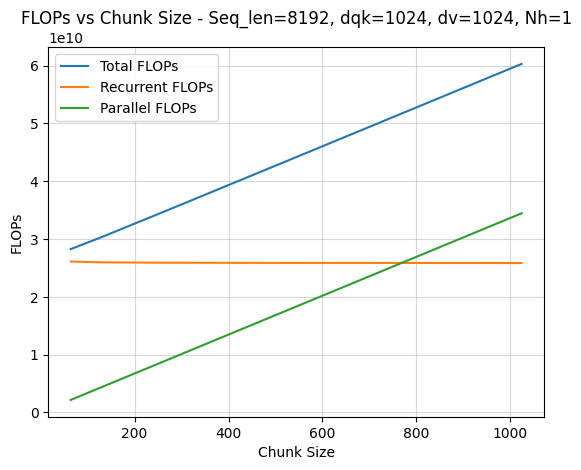

In [8]:
fig = make_chunkwise_flop_chunksize_sweep(
    seq_len=8192,
    chunk_sizes=[64, 128, 256, 512, 1024],
    dqk=1024,
    dv=1024,
    Nh=1,
    factor_exp=1,
    factor_max=1,
    factor_mask=1,
)

## FLOPs vs Sequence length

We see the number of flops is linear in sequence length for the chunkwise, while a pure parallel (red) is quadratic.

In [11]:
def make_chunkwise_flop_sequence_length_sweep(
    seq_lengths: list[int], chunk_size, dqk, dv, Nh, factor_exp, factor_max, factor_mask
):
    sequence_lengths = np.array(seq_lengths)

    flops_results_parallel = []
    flop_results = []
    for seq_len in seq_lengths:
        num_chunk = seq_len // chunk_size
        total_flops, fw_C_flops, fw_h_flops = count_flops_mlstm_chunkwise_fw(
            L=chunk_size,
            Nc=num_chunk,
            dqk=dqk,
            dv=dv,
            Nh=Nh,
            factor_exp=factor_exp,
            factor_mask=factor_mask,
            factor_max=factor_max,
        )
        flop_results.append([total_flops, fw_C_flops, fw_h_flops])

        # parallel baseline with only one chunk of chunk_size=seq_len
        total_flops_p, fw_C_flops_p, fw_h_flops_p = count_flops_mlstm_chunkwise_fw(
            L=seq_len,
            Nc=1,
            dqk=dqk,
            dv=dv,
            Nh=Nh,
            factor_exp=factor_exp,
            factor_mask=factor_mask,
            factor_max=factor_max,
        )
        flops_results_parallel.append([total_flops_p, fw_C_flops_p, fw_h_flops_p])
        print(f"seq_len={seq_len}, chunkwise FLOPs={total_flops / 1e6:.2f}M, parallel FLOPs={total_flops_p / 1e6:.2f}M")

    flop_results = np.array(flop_results)
    flops_results_parallel = np.array(flops_results_parallel)
    fig, ax = plt.subplots()

    ax.plot(sequence_lengths, flop_results[:, 0], label="Total FLOPs")
    ax.plot(sequence_lengths, flop_results[:, 1], label="Recurrent FLOPs")
    ax.plot(sequence_lengths, flop_results[:, 2], label="Parallel FLOPs")
    ax.plot(
        sequence_lengths,
        flops_results_parallel[:, 0],
        label="Total FLOPs - Parallel",
        color="red",
    )

    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("FLOPs")
    ax.set_title(
        f"FLOPs vs Sequence Length - chunk_size={chunk_size}, dqk={dqk}, dv={dv}, Nh={Nh}"
    )
    ax.grid(alpha=0.5)
    ax.legend()
    return fig

seq_len=512, chunkwise FLOPs=1765.63M, parallel FLOPs=2692.88M
seq_len=1024, chunkwise FLOPs=3531.27M, parallel FLOPs=7536.65M
seq_len=2048, chunkwise FLOPs=7062.53M, parallel FLOPs=23683.15M
seq_len=4096, chunkwise FLOPs=14125.07M, parallel FLOPs=81812.02M
seq_len=8192, chunkwise FLOPs=28250.13M, parallel FLOPs=301413.23M


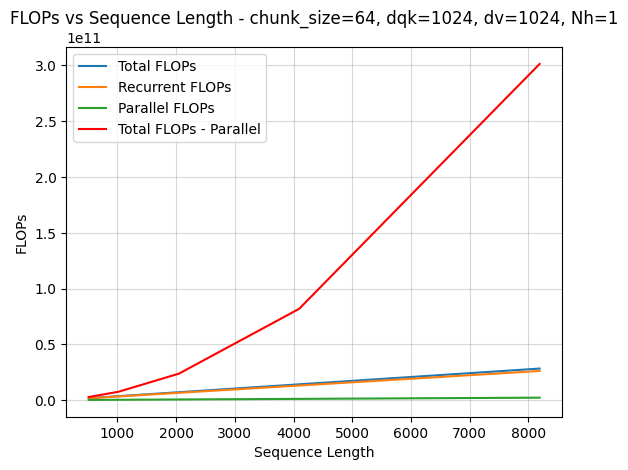

In [12]:
fig = make_chunkwise_flop_sequence_length_sweep(
    seq_lengths=[512, 1024, 2048, 4096, 8192],
    chunk_size=64,
    dqk=1024,
    dv=1024,
    Nh=1,
    factor_exp=1,
    factor_max=1,
    factor_mask=1,
)